In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for file editing
import shutil # for console commands
#print(os.listdir("../CVproject/102flowers/"))

In [54]:
os.listdir("../CVproject/102flowers/") #jpg folder should be available


['102flowers.tgz',
 '102segmentations.tgz',
 'distancematrices102.mat',
 'imagelabels.mat',
 'jpg',
 'segmim']

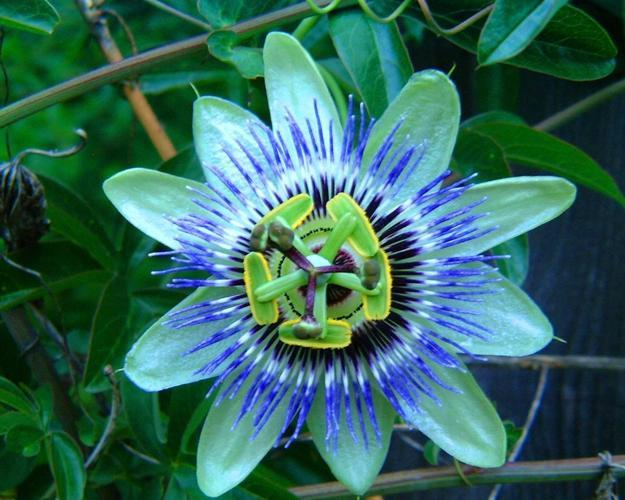

In [55]:
from PIL import Image
Image.open("../CVproject/102flowers/jpg/image_00002.jpg")

In [56]:
#load images as np arrays
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img

In [59]:
#all images are loaded as np arrays
images=[]
labels=[]
total=1000
j=1
for i in range(1, total+1): 
    fname="../CVproject/102flowers/jpg/image_"    
    fpath = os.path.join(fname + str(i).zfill(5) + ".jpg")
    images.append(load_data(fpath))
    labels.append(j) #labels are created as well
    if i%80==0: j+=1

In [60]:
print(len(images))

1000


In [61]:
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(total,1) # labels are also converted to (1360,1)

In [62]:
images.shape

(1000, 224, 224, 3)

In [63]:
from sklearn.model_selection import train_test_split 
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size = 0.8, random_state =  104)

In [64]:
print(len(train_images), len(test_images))

800 200


c:\python38\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


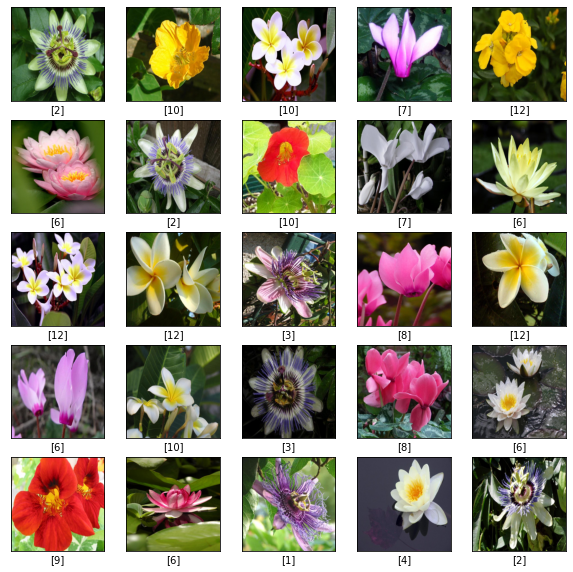

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) # plot 25 images
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]/255, cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

In [66]:
# dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np
def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname): #check if the folder exists; if not make dir
        os.mkdir(dirname)
    n=0
    
    for i in data:
        
        label_n=labels[n][0]
        subfolder = folder + "/" + str(label_n) 
        if not os.path.exists(subfolder): # create subfolders with categories
            os.mkdir(subfolder)  
        filepath =  subfolder + "/" + str(n)+ ".jpg"
        cv2.imwrite(filepath, data[n]) #save image to corresponding subfolders
        n+=1

In [67]:
create_images(train_images, train_labels, 'train') #save image to corresponding subfolders
create_images(test_images, test_labels, 'test')

In [68]:
train_dir =os.path.realpath('train')
validation_dir = os.path.realpath('test')
image_size = 224

In [73]:
# use vgg16 pre-trained model with trainable densely connected output layer

from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers except for the last layer: 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(13, activation='softmax'))
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 13)                13325     
Total params: 40,419,149
Trainable params: 32,783,885
Non-trainable params: 7,635,264
_________________________________________________________________


In [74]:
# image augmentation for train set and image resizing for validation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # this function will generate augmented images in real time
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255) # for validation we don't need to augment

train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory( # this function takes images from folders and feeds to Imagedatagenerator
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 875 images belonging to 13 classes.
Found 217 images belonging to 13 classes.


In [75]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4), # learning rate should be small so previously learned weights don't vanish
              metrics=['acc', 'top_k_categorical_accuracy'])

In [ ]:
# train the model with augmented images in real-time
# make sure your GPU is available, otherwise training can take longer
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=0)

In [ ]:
print(' training top 5:',history.history['top_k_categorical_accuracy'][-1], '\n',
      'val top 5:', history.history['val_top_k_categorical_accuracy'][-1], '\n')

In [ ]:
# plot the accuracy history
import matplotlib.pyplot as plt
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy %')
 plt.plot(history.epoch, np.array(history.history['acc']),
 label='Train Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_acc']),
 label = 'Val Accuracy')
 plt.legend()
 plt.ylim([0.5, 1])
plot_history(history)

In [ ]:
# remove dataset files
import shutil
shutil.rmtree(os.path.realpath('17category-flowers-py')) 
shutil.rmtree(os.path.realpath('train'))
shutil.rmtree(os.path.realpath('test'))